<a href="https://colab.research.google.com/github/norakardum/yield-pca/blob/main/yield_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import quandl 
import pandas
import matplotlib
import numpy as np
import changefinder as cf
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
quandl.ApiConfig.api_key = 'TKNqom36rhKrxyc5rf8T'
yield_curve = quandl.get('USTREASURY/YIELD', start_date='2006-01-03', end_date='2021-01-03') #get 15 years of us treasury data

In [5]:
yield_curve.head() #show the first five rows of the dataframe

,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
2006-01-03,4.05,NaN,4.16,4.40,4.38,4.34,4.30,4.30,4.32,4.37,4.62,NaN
2006-01-04,4.03,NaN,4.19,4.37,4.35,4.31,4.28,4.28,4.31,4.36,4.60,NaN
2006-01-05,4.05,NaN,4.20,4.37,4.36,4.32,4.29,4.29,4.31,4.36,4.61,NaN
2006-01-06,4.06,NaN,4.22,4.39,4.38,4.36,4.32,4.32,4.33,4.38,4.63,NaN
2006-01-09,4.09,NaN,4.23,4.40,4.39,4.36,4.32,4.32,4.34,4.38,4.63,NaN


In [6]:
# general information about the set we're working with
yield_curve.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3754 entries, 2006-01-03 to 2020-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1 MO    3754 non-null   float64
 1   2 MO    552 non-null    float64
 2   3 MO    3751 non-null   float64
 3   6 MO    3754 non-null   float64
 4   1 YR    3754 non-null   float64
 5   2 YR    3754 non-null   float64
 6   3 YR    3754 non-null   float64
 7   5 YR    3754 non-null   float64
 8   7 YR    3754 non-null   float64
 9   10 YR   3754 non-null   float64
 10  20 YR   3754 non-null   float64
 11  30 YR   3728 non-null   float64
dtypes: float64(12)
memory usage: 381.3 KB


In [7]:
#checking how much information is missing per column
yield_curve.isnull().sum()

1 MO        0
2 MO     3202
3 MO        3
6 MO        0
1 YR        0
2 YR        0
3 YR        0
5 YR        0
7 YR        0
10 YR       0
20 YR       0
30 YR      26
dtype: int64

In [8]:
#we will drop the second column due to missing data, and 30 YR as it is not of interest in this project
yield_curve.drop(['2 MO'], axis = 1, inplace = True)
yield_curve.drop(['30 YR'], axis = 1, inplace = True)

In [9]:
#for 3MO column we wil fill the missing data with the immediate previous value 
yield_curve.ffill(inplace=True)

In [10]:
#it is difficult to work with dates so we will reset the index to numbering
#we will store a separate dataframe to know which Id belongs to which date
yield_curve = yield_curve.reset_index()
dates = yield_curve['Date']
yield_curve.drop(['Date'], axis = 1, inplace = True)

In [11]:
#yield_curve.isnull().sum()
yield_curve.info() #we can check again if everything is alright and the new shape of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3754 entries, 0 to 3753
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1 MO    3754 non-null   float64
 1   3 MO    3754 non-null   float64
 2   6 MO    3754 non-null   float64
 3   1 YR    3754 non-null   float64
 4   2 YR    3754 non-null   float64
 5   3 YR    3754 non-null   float64
 6   5 YR    3754 non-null   float64
 7   7 YR    3754 non-null   float64
 8   10 YR   3754 non-null   float64
 9   20 YR   3754 non-null   float64
dtypes: float64(10)
memory usage: 293.4 KB


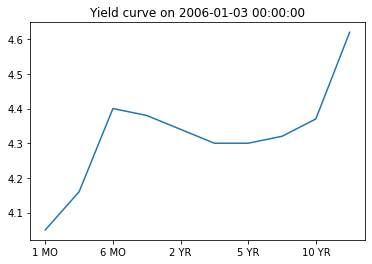

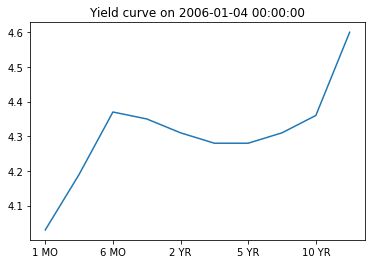

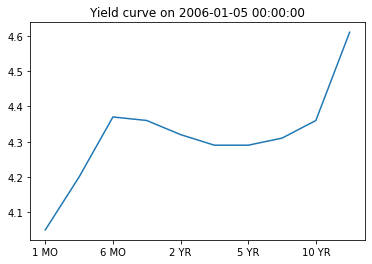

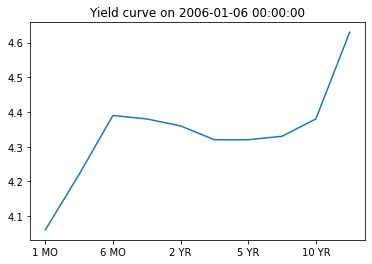

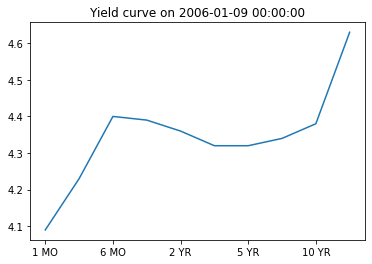

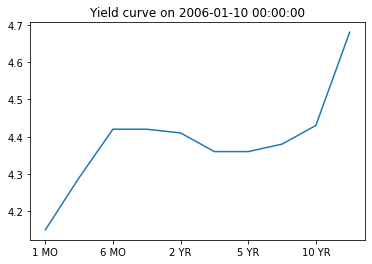

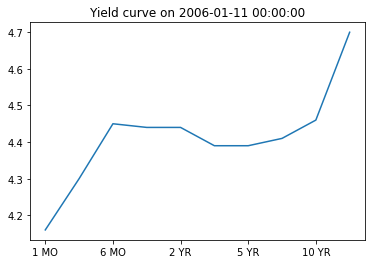

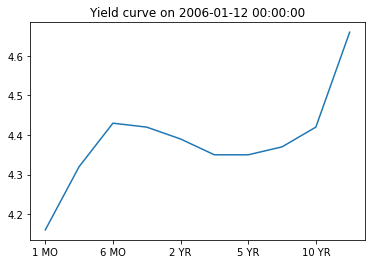

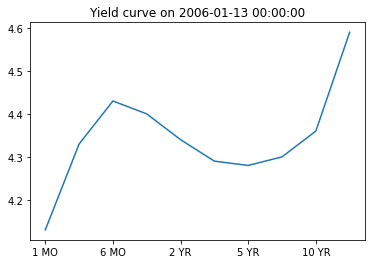

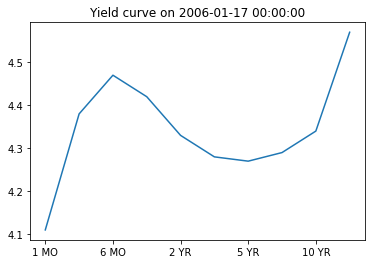

In [12]:
#visualizing first ten yield curves
for i in range(0,10):
  yield_curve.transpose()[i].plot()
  plt.title('Yield curve on '+str(dates[i]))
  plt.show()

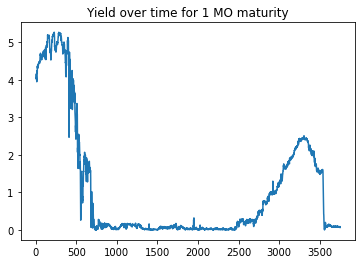

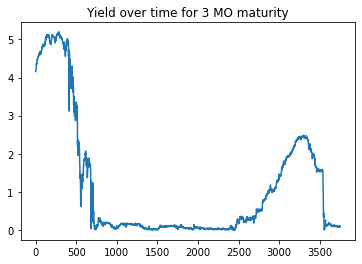

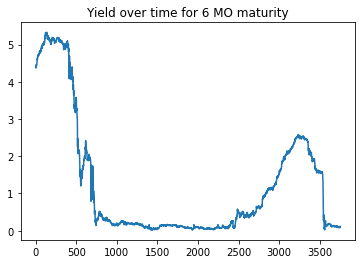

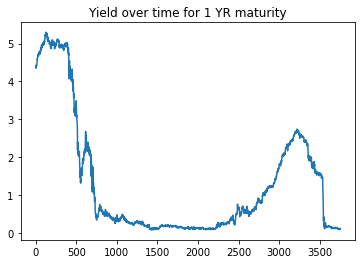

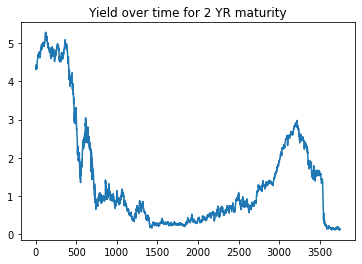

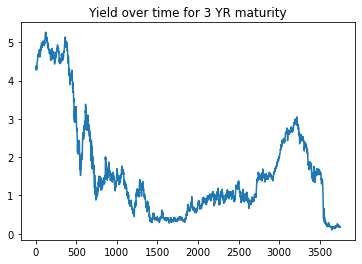

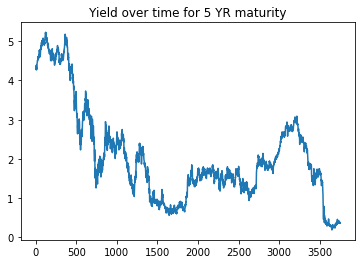

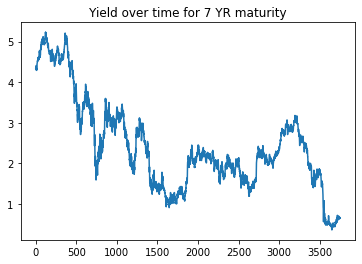

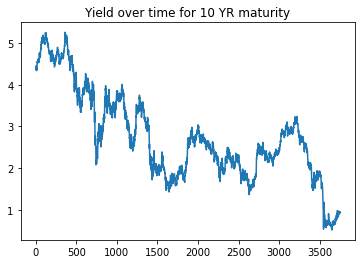

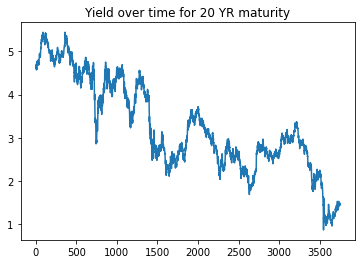

In [13]:
#visualizing the time changing of particular maturity yield
for col in yield_curve.columns:
  yield_curve[col].plot()
  plt.title('Yield over time for '+str(col)+ ' maturity')
  plt.show()

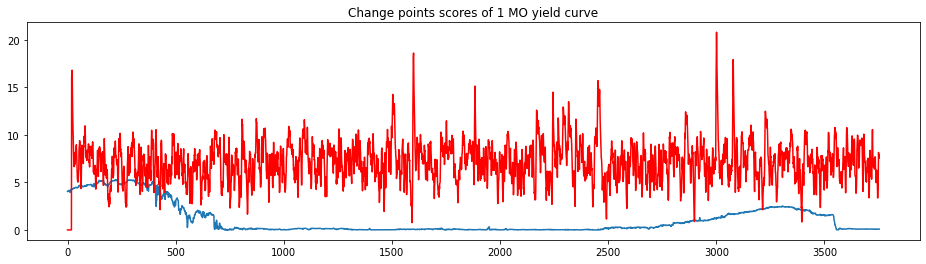

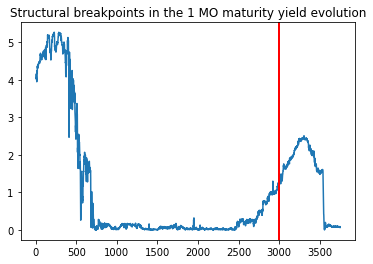

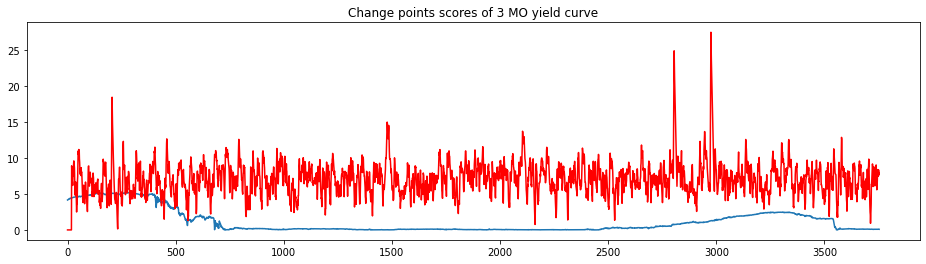

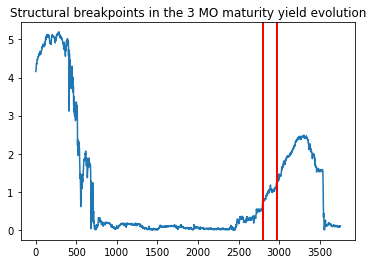

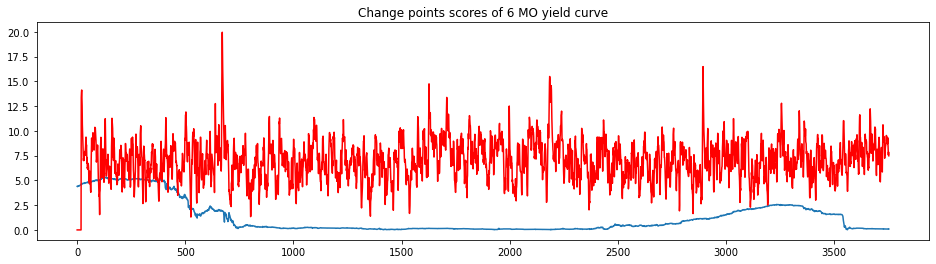

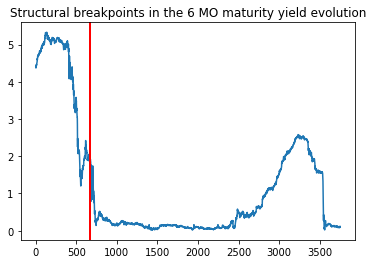

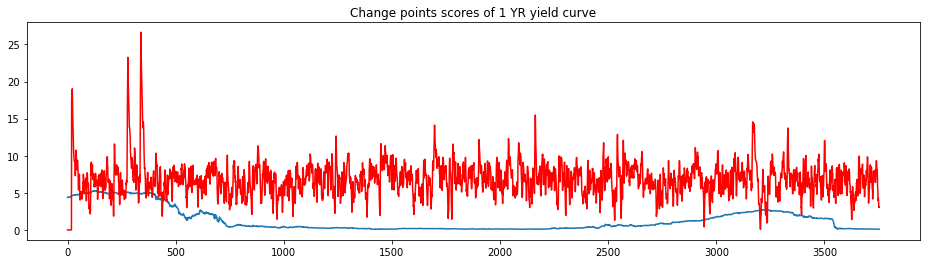

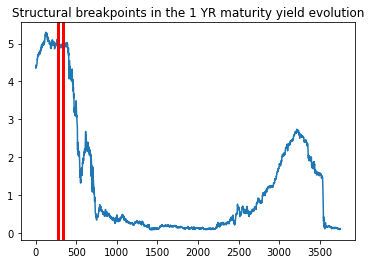

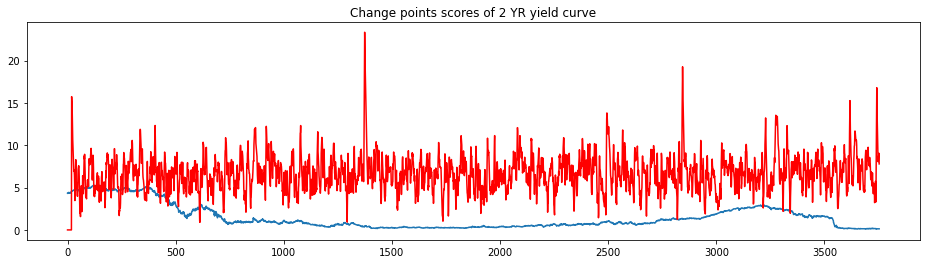

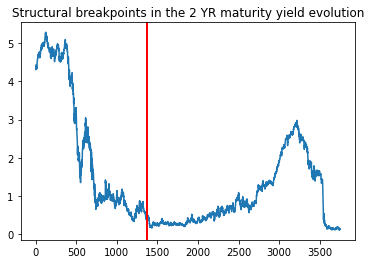

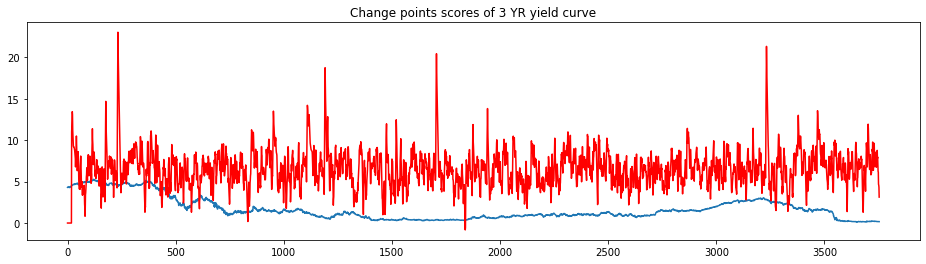

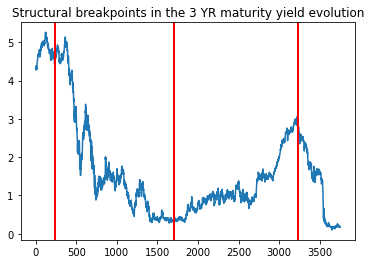

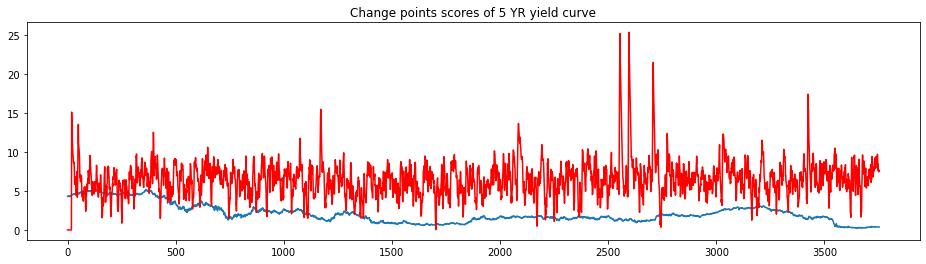

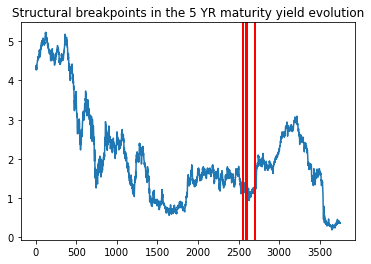

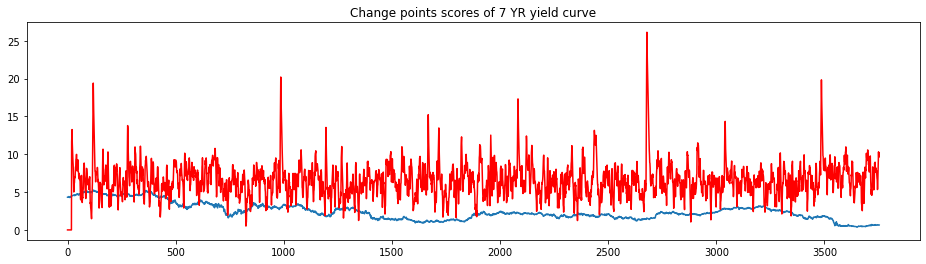

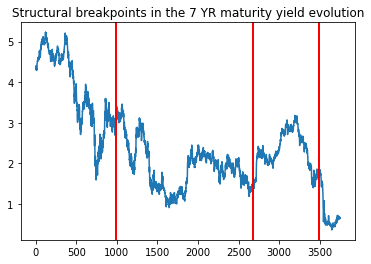

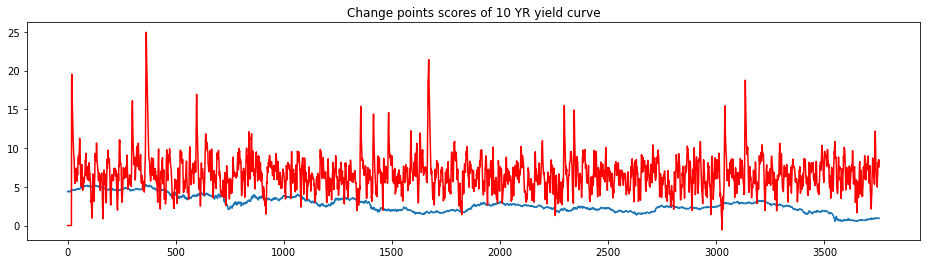

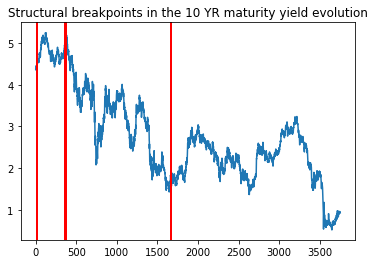

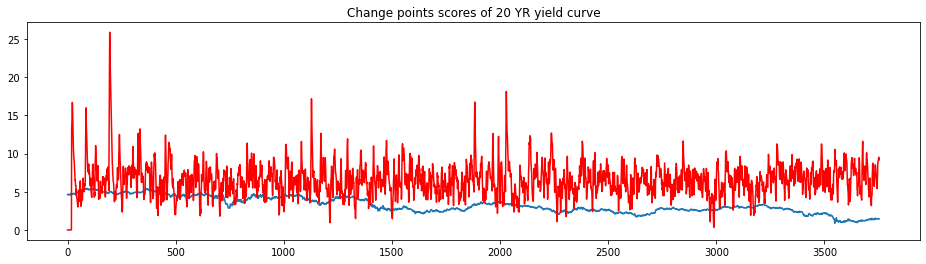

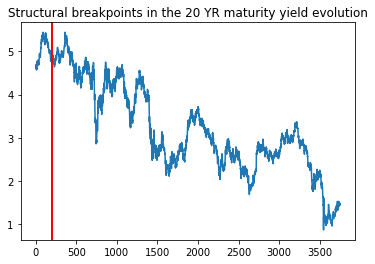

In [14]:
def findChangePoints(data, order):
    cp = cf.ChangeFinder(order=order)
    change_points = [cp.update(p) for p in data]
    return change_points

#we will check structural changes by iterating over all columns of the dataset
for column in yield_curve.columns:
  column_cp = findChangePoints(yield_curve[column], 5)
  plt.figure(figsize=(16,4))
  plt.plot(yield_curve[column])
  plt.plot(column_cp, color = 'red')
  plt.title('Change points scores of ' + str(column) + ' yield curve')
  plt.show()
  Q1 = np.percentile(column_cp, 5, interpolation = 'midpoint') 
  Q3 = np.percentile(column_cp, 95, interpolation = 'midpoint') 
  IQR = Q3 - Q1 
  upper_break_points = np.where(column_cp >= (Q3+1.5*IQR))
  plt.plot(yield_curve[column])
  for i in upper_break_points[0]:
    plt.axvline(i,lw=2, color='red')
  plt.title('Structural breakpoints in the ' + str(column) + ' maturity yield evolution')
  plt.show()


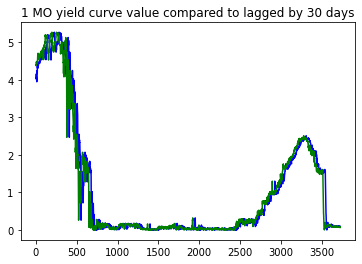

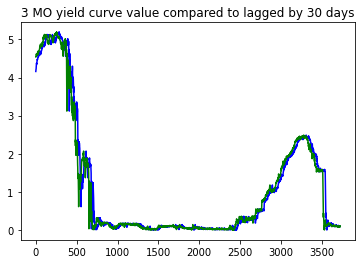

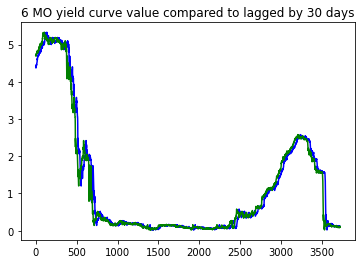

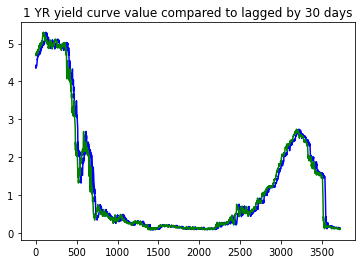

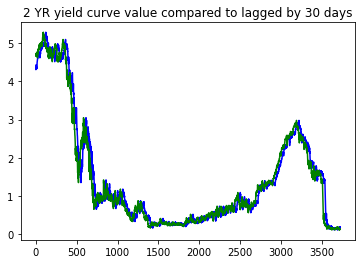

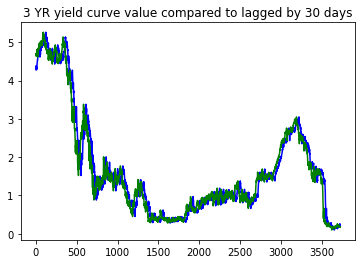

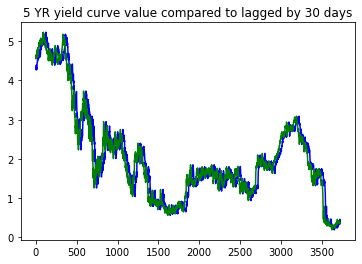

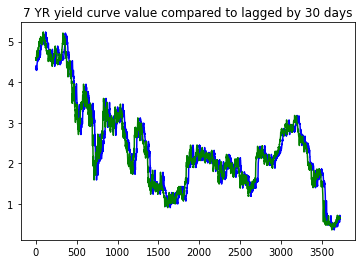

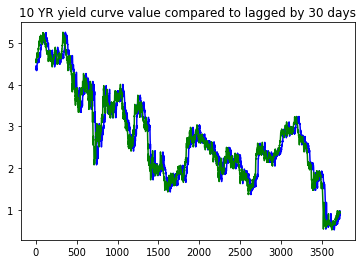

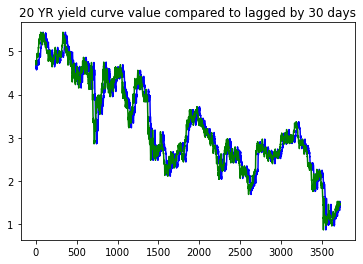

In [15]:
for column in yield_curve.columns: #here we plot the yield curve and its 30 day lag
  plt.plot(yield_curve[column][:-30], color = 'blue')
  plt.plot(range(0, 3724), yield_curve[column][30:], color = 'green')
  plt.title(column + ' yield curve value compared to lagged by 30 days')
  plt.show()

In [16]:
#standardizing the data before proceeding to building principal components
standard_yield_curve = pandas.DataFrame(StandardScaler().fit_transform(yield_curve.values), columns=yield_curve.columns, index=yield_curve.index)

           1 MO      3 MO      6 MO  ...      7 YR     10 YR     20 YR
1 MO   1.000266  0.998162  0.994073  ...  0.794706  0.699488  0.552036
3 MO   0.998162  1.000266  0.998287  ...  0.804260  0.708570  0.559672
6 MO   0.994073  0.998287  1.000266  ...  0.817653  0.722842  0.573779
1 YR   0.988169  0.993913  0.998460  ...  0.833448  0.738410  0.588139
2 YR   0.971728  0.979405  0.986832  ...  0.878256  0.786841  0.639222
3 YR   0.947529  0.956108  0.965494  ...  0.922062  0.839744  0.700981
5 YR   0.875998  0.885569  0.897897  ...  0.984072  0.933589  0.827161
7 YR   0.794706  0.804260  0.817653  ...  1.000266  0.980666  0.908645
10 YR  0.699488  0.708570  0.722842  ...  0.980666  1.000266  0.971611
20 YR  0.552036  0.559672  0.573779  ...  0.908645  0.971611  1.000266

[10 rows x 10 columns]


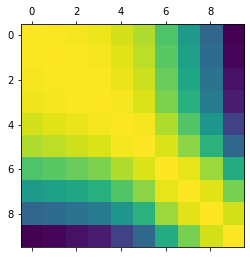

In [17]:
#correlation matrix of the yield curves
print(standard_yield_curve.cov())
plt.matshow(standard_yield_curve.cov())
plt.show()

In [18]:
#find the eigenvalues and vectors for the data
eigval, eigvec = np.linalg.eig(standard_yield_curve.cov())
#create a new dataframe for eigenvalues and eigenvectors
yield_curve_eigval = pandas.DataFrame({'eigenvalues': eigval}, index = range(1, 11))
yield_curve_eigval['Covariance explained'] = yield_curve_eigval['eigenvalues'] / np.sum(yield_curve_eigval['eigenvalues'])
yield_curve_eigval

,eigenvalues,Covariance explained
1,8.837114,0.883476
2,1.072539,0.107225
3,0.075798,0.007578
4,0.011796,0.001179
5,0.002837,0.000284
6,0.001080,0.000108
7,0.000710,0.000071
8,0.000166,0.000017
9,0.000205,0.000020
10,0.000420,0.000042


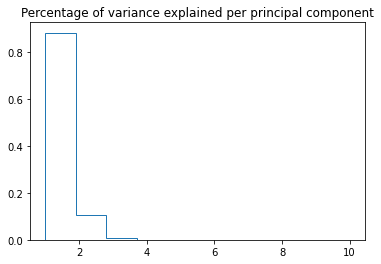

In [19]:
plt.hist(range(1, 11), weights = yield_curve_eigval['Covariance explained'].values, histtype = 'step')
plt.title('Percentage of variance explained per principal component')
plt.show()

In [20]:
yield_curve_eigval['Covariance explained'].values

array([8.83475983e-01, 1.07225287e-01, 7.57774832e-03, 1.17927498e-03,
       2.83577233e-04, 1.08009417e-04, 7.10127289e-05, 1.66419775e-05,
       2.04893789e-05, 4.19756537e-05])

In [21]:
## following the definition, we need the dot product to retrieve the components
principal_components = standard_yield_curve.dot(eigvec)
principal_components = pandas.DataFrame((principal_components)*(-1))
principal_components

,0,1,2,3,4,5,6,7,8,9
0,5.739614,0.390410,0.028518,0.082175,0.015214,-0.009595,0.012914,-0.021684,0.006417,-0.004187
1,5.701407,0.398105,0.021673,0.065460,0.007487,-0.022075,-0.009820,-0.011356,0.002011,-0.005683
2,5.719559,0.400160,0.018038,0.064878,0.018139,-0.022145,-0.006994,-0.008531,-0.003048,-0.003723
3,5.774926,0.390078,0.029416,0.072676,0.022809,-0.023728,-0.011390,-0.013306,-0.007908,-0.001787
4,5.789995,0.398015,0.021337,0.061663,0.023463,-0.020481,-0.005661,-0.012766,-0.005613,-0.008207
...,...,...,...,...,...,...,...,...,...,...
3749,-3.496670,1.447579,-0.154282,0.004919,0.002481,-0.014374,0.003011,-0.001926,-0.001455,-0.012056
3750,-3.486610,1.457619,-0.159761,0.008965,-0.004788,-0.021996,0.002951,-0.001399,-0.005981,-0.000844
3751,-3.488431,1.447253,-0.163813,0.013624,-0.009347,-0.026580,0.007895,-0.002003,0.005545,-0.008408
3752,-3.505695,1.446347,-0.146488,0.019807,-0.006399,-0.022424,0.011951,0.008374,-0.001386,-0.015783


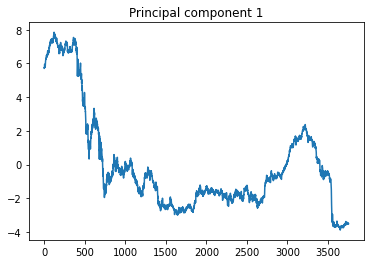

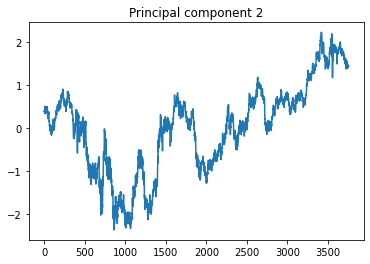

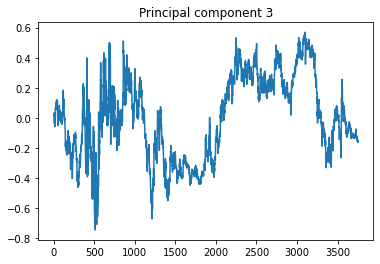

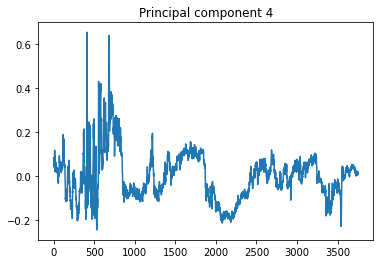

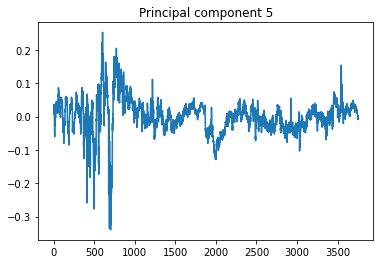

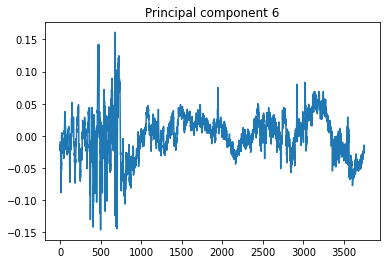

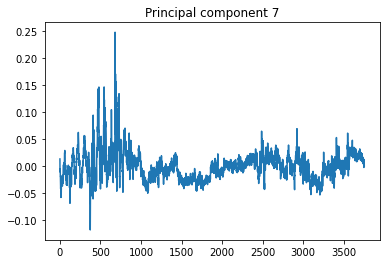

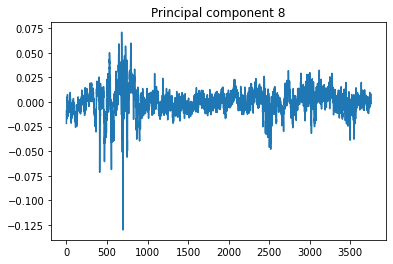

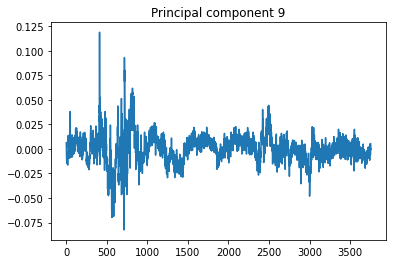

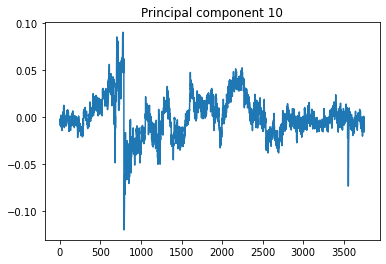

In [22]:
#visualization of all principal components
for i in range(0, 10):
  principal_components[i].plot()
  plt.title('Principal component '+str(i+1))
  plt.show()


In [23]:
#finding correlation of first component to yield curves
merged_yield_components = pandas.concat([yield_curve, principal_components], axis=1) #for simplicity, we will create one dataframe so we can easily retrieve any correlation of interest
print(merged_yield_components.corr()[0][:10]) #we are interested in the correlation of first component (called zero) to the curves


1 MO     0.945235
3 MO     0.951798
6 MO     0.959200
1 YR     0.966052
2 YR     0.981464
3 YR     0.990666
5 YR     0.982901
7 YR     0.946312
10 YR    0.885490
20 YR    0.769198
Name: 0, dtype: float64


In [24]:
#the highest correlation is:
merged_yield_components.corr()[0][:10].max()

0.990666405562183

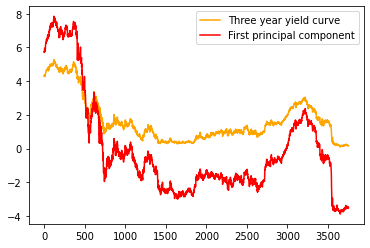

In [25]:
#visualy inspecting the similarity with highest correlated curve and the first principal component
plt.plot(yield_curve['3 YR'], label = 'Three year yield curve', color = 'orange')
plt.plot(principal_components[0], label = 'First principal component', color = 'red')
plt.legend(loc = 'best')

In [26]:
## slope is the first derivative delta y / delta m
#since delta m is the same for all points, we can simplify the derivative to Delta y which is given with the difference between two maturities:
slope = yield_curve.transpose().diff().transpose()

## we check again if there is correlation between the actual slope and the second principal component
merged_slope = pandas.concat([slope, principal_components*(-1)], axis=1) 
print(merged_slope.corr()[1][1:10])

3 MO     0.076462
6 MO     0.226657
1 YR     0.455081
2 YR     0.677251
3 YR     0.812575
5 YR     0.867730
7 YR     0.780337
10 YR    0.675797
20 YR    0.656890
Name: 1, dtype: float64


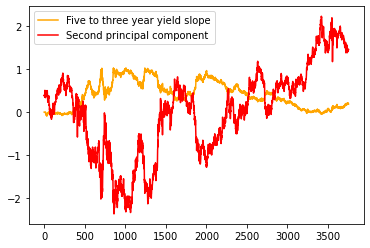

In [27]:
#visualize the highly correlated 5YR - 3YR slope with the second component
plt.plot(slope['5 YR'], label = 'Five to three year yield slope', color = 'orange')
plt.plot(principal_components[1], label = 'Second principal component', color = 'red')
plt.legend(loc = 'best')

In [28]:
#slopes with different separations between maturities:
slope2 = yield_curve.transpose().diff(periods = 2).transpose()
slope3 = yield_curve.transpose().diff(periods = 3).transpose()
slope4 = yield_curve.transpose().diff(periods = 4).transpose()
slope5 = yield_curve.transpose().diff(periods = 5).transpose()
slope6 = yield_curve.transpose().diff(periods = 6).transpose()
slope7= yield_curve.transpose().diff(periods = 7).transpose()
slope8 = yield_curve.transpose().diff(periods = 8).transpose()
slope9 = yield_curve.transpose().diff(periods = 9).transpose()

for i in range(2, 10):
  merged_slope = pandas.concat([eval('slope'+str(i)), principal_components*(-1)], axis=1) 
  print('Correlation of second \n principal component and slope \n with '+str(i)+'-step maturities \n separation:')
  print(merged_slope.corr()[1][1:10])

Correlation of second 
 principal component and slope 
 with 2-step maturities 
 separation:
3 MO          NaN
6 MO     0.172552
1 YR     0.400867
2 YR     0.635809
3 YR     0.757521
5 YR     0.866329
7 YR     0.842670
10 YR    0.748734
20 YR    0.676046
Name: 1, dtype: float64
Correlation of second 
 principal component and slope 
 with 3-step maturities 
 separation:
3 MO          NaN
6 MO          NaN
1 YR     0.328171
2 YR     0.628488
3 YR     0.727827
5 YR     0.837801
7 YR     0.855151
10 YR    0.819814
20 YR    0.725893
Name: 1, dtype: float64
Correlation of second 
 principal component and slope 
 with 4-step maturities 
 separation:
3 MO          NaN
6 MO          NaN
1 YR          NaN
2 YR     0.584880
3 YR     0.732263
5 YR     0.822320
7 YR     0.843797
10 YR    0.844283
20 YR    0.794889
Name: 1, dtype: float64
Correlation of second 
 principal component and slope 
 with 5-step maturities 
 separation:
3 MO          NaN
6 MO          NaN
1 YR          NaN
2 YR          Na

In [29]:
## we will attempt to calculate the curvature per the given equation
#the first derivative is already stored in the variable slope
#the second derivative:
second_slope = yield_curve.transpose().diff().diff().transpose()
curvature = second_slope.div(slope.mul(slope).add(1).pow((3/2)))
print(curvature.head())

#check the correlation to third component with the same approach as before
merged_curvature = pandas.concat([curvature, principal_components*(-1)], axis=1) 
print(merged_curvature.corr()[2][2:10])

   1 MO  3 MO      6 MO      1 YR  ...  5 YR      7 YR     10 YR     20 YR
0   NaN   NaN  0.119526 -0.259844  ...  0.04  0.019988  0.029888  0.182615
1   NaN   NaN  0.019066 -0.199880  ...  0.03  0.029960  0.019925  0.174691
2   NaN   NaN  0.019163 -0.179973  ...  0.03  0.019988  0.029888  0.182615
3   NaN   NaN  0.009582 -0.179973  ...  0.04  0.009999  0.039850  0.182615
4   NaN   NaN  0.028745 -0.179973  ...  0.04  0.019988  0.019952  0.191746

[5 rows x 10 columns]
6 MO    -0.075246
1 YR    -0.210901
2 YR    -0.223595
3 YR     0.593717
5 YR     0.484533
7 YR     0.396952
10 YR    0.619441
20 YR   -0.021554
Name: 2, dtype: float64


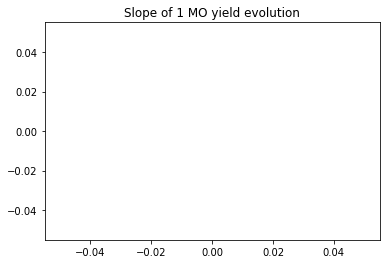

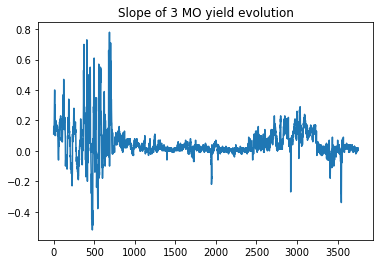

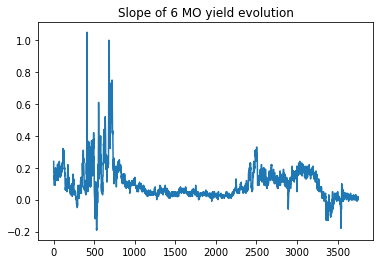

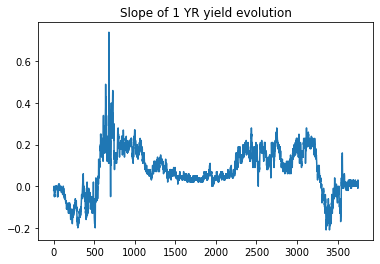

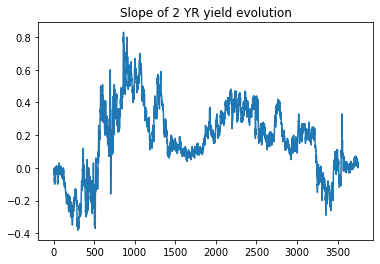

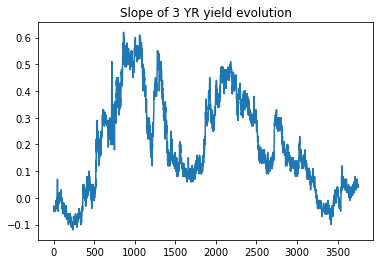

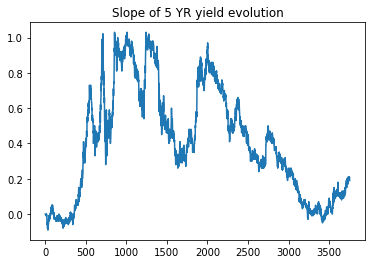

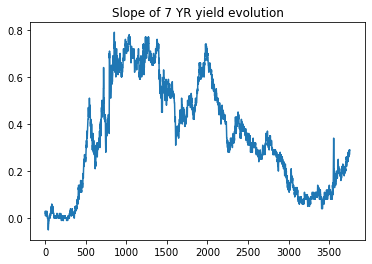

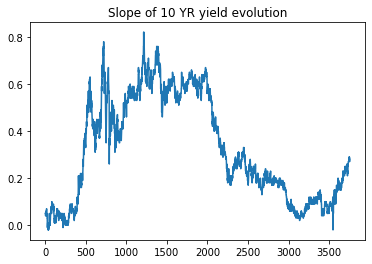

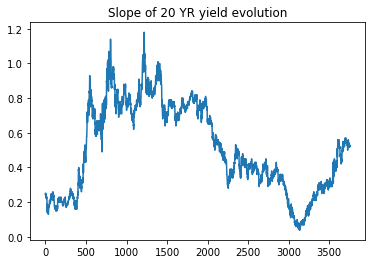

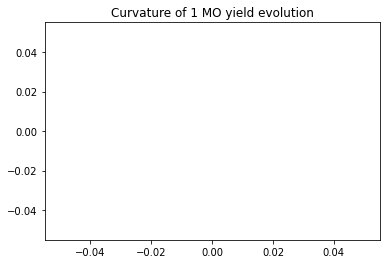

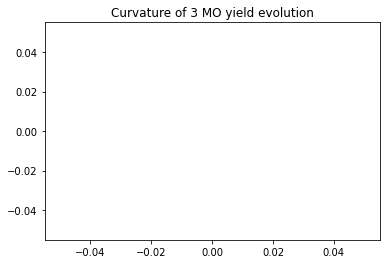

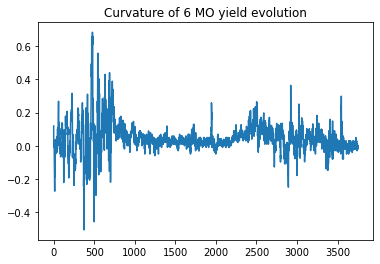

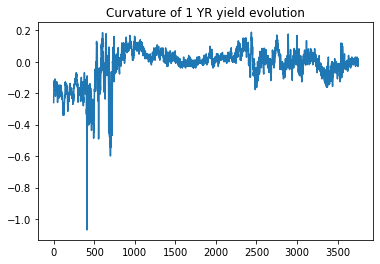

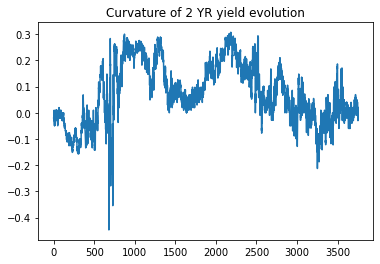

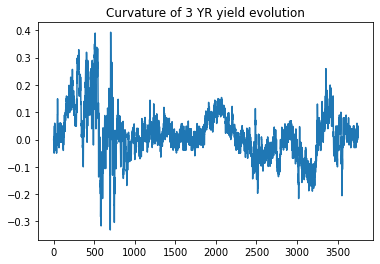

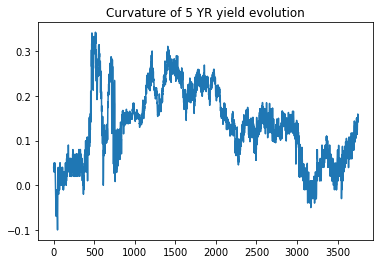

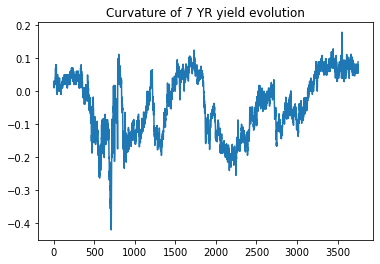

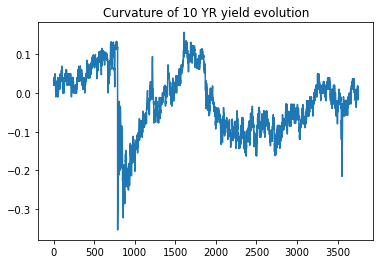

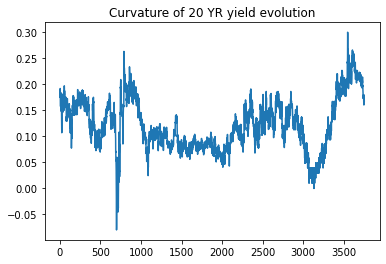

In [30]:
for x in slope.columns:
  slope[x].plot()
  plt.title('Slope of '+str(x)+ ' yield evolution')
  plt.show()

for x in curvature.columns:
  curvature[x].plot()
  plt.title('Curvature of '+str(x)+ ' yield evolution')
  plt.show()